In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go



# **Delay Analysis**

In [3]:
delay_df = pd.read_excel('https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_delay_analysis.xlsx')

In [4]:
delay_df.shape

(21310, 7)

--> This dataframe contains 21310 rows and 7 columns

In [5]:
delay_df.head()

,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
0,505000,363965,mobile,canceled,NaN,NaN,NaN
1,507750,269550,mobile,ended,-81.0,NaN,NaN
2,508131,359049,connect,ended,70.0,NaN,NaN
3,508865,299063,connect,canceled,NaN,NaN,NaN
4,511440,313932,mobile,ended,NaN,NaN,NaN


In [6]:
delay_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21310 entries, 0 to 21309
Data columns (total 7 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   rental_id                                   21310 non-null  int64  
 1   car_id                                      21310 non-null  int64  
 2   checkin_type                                21310 non-null  object 
 3   state                                       21310 non-null  object 
 4   delay_at_checkout_in_minutes                16346 non-null  float64
 5   previous_ended_rental_id                    1841 non-null   float64
 6   time_delta_with_previous_rental_in_minutes  1841 non-null   float64
dtypes: float64(3), int64(2), object(2)
memory usage: 1.1+ MB


In [7]:
print("\nPercentage of missing values: ")
display(100 * delay_df.isnull().sum() / delay_df.shape[0])


Percentage of missing values: 


,0
rental_id,0.000000
car_id,0.000000
checkin_type,0.000000
state,0.000000
delay_at_checkout_in_minutes,23.294228
previous_ended_rental_id,91.360863
time_delta_with_previous_rental_in_minutes,91.360863


In [8]:
delay_df_sheet2 = pd.read_excel(
    'https://full-stack-assets.s3.eu-west-3.amazonaws.com/Deployment/get_around_delay_analysis.xlsx',
    sheet_name=1)

# Ajuster les options d'affichage pour voir tout le texte
pd.set_option('display.max_colwidth', None)


display(delay_df_sheet2)

,field name,Comment
0,rental_id,Unique identifier of the rental
1,car_id,Unique identifier of the car
2,checkin_type,"Flow used for both checkin and checkout. (ie. access and return the car)\nmobile = rental agreement signed on the owner's smartphone\nconnect = car equiped with the Connect technology , opened by the driver with his smartphone.\nNote: paper contracts were excluded from the data as we have no data on their delay at checkout and it's negligible use case"
3,state,canceled means that the rental did not happen (was canceled by the driver or the owner).
4,delay_at_checkout_in_minutes,Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. Negative values mean that the driver returned the car in advance.
5,previous_ended_rental_id,id of the previous ended rental of the car (NULL when no previous rental or delay with previous rental higher than 12 hours)
6,time_delta_with_previous_rental_in_minutes,"Difference in minutes between this rental planned start time and the previous rental planned end time (when lower than 12 hours, NULL if higher)"


--> Lots of missing values in 3 columns:<br>
    *   **delay_at_checkout_in_minutes** : 23.29% <br>
    Difference in minutes between the rental end time requested by the driver when booking the car and the actual time the driver completed the checkout. --> Hypothesis : these missing values could correspond to canceled rental<br>
     *   **previous_ended_rental_id** : 91.36% and **time_delta_with_previous_rental_in_minutes** : 91.36% <br> As described in the documentation, NULL when no previous rental or delay with previous rental higher than 12 hours <br>

Let's check this information on missing values

In [9]:
#Missing values on delay_at_checkout_in_minutes because of canceled : hypothesis Ok except for one record

cancel_df = delay_df[(delay_df['state'] == 'canceled') ]
print(f"Number of canceled rentals  : {cancel_df.shape[0]}")

print("Canceled rentals with a completed delay at checkout:")
display(cancel_df[cancel_df['delay_at_checkout_in_minutes'].notnull()])

Number of canceled rentals  : 3265
Canceled rentals with a completed delay at checkout:


,rental_id,car_id,checkin_type,state,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
21002,559126,379544,mobile,canceled,-17468.0,NaN,NaN


This record might be a mistake : it means that the driver completed the checkout 17468 minuts (so 291h or 12 days ) before the rental end time requested by the driver when booking the car <br> --> But how could he complete the chekout if he canceled the rental?<br>
--> Moreover 17468 is considered an outlier in the dataset.

In [10]:
#Missing values on previous_ended_rental_id and time_delta_with_previous_rental_in_minutes :

#checking if missing values on both columns are linked
print(f"Nombre de lignes où les 2 colonnes sont renseignées simultanément :", delay_df[(delay_df['previous_ended_rental_id'].notnull()) &
                 (delay_df['time_delta_with_previous_rental_in_minutes'].notnull())].shape[0])

#checking if missing values on both columns when canceled
print("Nombre de lignes où les 2 colonnes sont vides simultanément pour les rentals annulés :", delay_df[(delay_df['state'] == 'canceled') & (delay_df['previous_ended_rental_id'].isnull()) & delay_df['time_delta_with_previous_rental_in_minutes'].isnull()].shape[0])
#checking if missing values on both columns when canceled
print("Nombre de lignes où les 2 colonnes sont renseignées simultanément pour les rentals annulés :", delay_df[(delay_df['state'] == 'canceled') & (delay_df['previous_ended_rental_id'].notnull()) & delay_df['time_delta_with_previous_rental_in_minutes'].notnull()].shape[0])



Nombre de lignes où les 2 colonnes sont renseignées simultanément : 1841
Nombre de lignes où les 2 colonnes sont vides simultanément pour les rentals annulés : 3036
Nombre de lignes où les 2 colonnes sont renseignées simultanément pour les rentals annulés : 229


--> we can notice that some rental have been canceled while the car was already booked : maybe because of a long dela y in check of the previous car? <br>
Let's check below

In [11]:
 Canceled_with_previouscar=(delay_df[(delay_df['state'] == 'canceled') & (delay_df['previous_ended_rental_id'].notnull()) & delay_df['time_delta_with_previous_rental_in_minutes'].notnull()])

 #display(Canceled_with_previouscar)


# 2. Faire une jointure pour retrouver les infos de la location précédente
merged = Canceled_with_previouscar.merge(
    delay_df[['rental_id', 'delay_at_checkout_in_minutes']],
    left_on='previous_ended_rental_id',
    right_on='rental_id',
    how='left',
    suffixes=('', '_previous')
)
print(merged.shape)
negatives_count = (merged['delay_at_checkout_in_minutes_previous'] < 0).sum()
print(f"Nombre de valeurs négatives : {negatives_count}")
positive_count = (merged['delay_at_checkout_in_minutes_previous'] >0).sum()
print(f"Nombre de valeurs positives : {positive_count}")
null_count = (merged['delay_at_checkout_in_minutes_previous'].isnull()).sum()
print(f"Nombre de valeurs nulles : {null_count}")

(229, 9)
Nombre de valeurs négatives : 100
Nombre de valeurs positives : 106
Nombre de valeurs nulles : 23


--> we can notice that less than half the previous rental was in delay (positive number). <br>
So it couldn't be the main reason of the canceled rental. We will explore it later in details.

In [12]:
delay_df.describe()

,rental_id,car_id,delay_at_checkout_in_minutes,previous_ended_rental_id,time_delta_with_previous_rental_in_minutes
count,21310.000000,21310.000000,16346.000000,1841.000000,1841.000000
mean,549712.880338,350030.603426,59.701517,550127.411733,279.288430
std,13863.446964,58206.249765,1002.561635,13184.023111,254.594486
min,504806.000000,159250.000000,-22433.000000,505628.000000,0.000000
25%,540613.250000,317639.000000,-36.000000,540896.000000,60.000000
50%,550350.000000,368717.000000,9.000000,550567.000000,180.000000
75%,560468.500000,394928.000000,67.000000,560823.000000,540.000000
max,576401.000000,417675.000000,71084.000000,575053.000000,720.000000


## GLOBAL ANALYSIS

In [13]:
#Distribution of checkin_type

fig=px.pie(delay_df, names='checkin_type')

fig.show()



In [14]:
# Préparer les données (si nécessaire)

# Comptage des occurrences de chaque valeur de la colonne 'state'
state_counts = delay_df['state'].value_counts().reset_index()
state_counts.columns = ['state', 'count']  # Renommer les colonnes


# Créer le bar chart horizontal
fig = px.bar(
    state_counts,
    x='count',
    y='state',
    orientation='h',  # horizontal
    color='state',    # couleur différente par état
    text='count',     # afficher les valeurs
    title='Répartition par état'
)

# Améliorer l'apparence
fig.update_traces(textposition='outside')  # placer les valeurs à l'extérieur des barres
fig.update_layout(yaxis=dict(categoryorder='total ascending'))  # ordre des barres
fig.show()

3265 rated are canceled, ie 15% of the amount

## DETAILLED ANALYSIS

la question principale de notre étude repose sur la recherche d'un seuil, sur le délai minimal de retard acceptable.<br>
evaluons déjà s'il existe des outliers dans les valeurs actuelles?

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
positive_delays = delay_df[delay_df['delay_at_checkout_in_minutes'] >= 0]
fig=px.box(y=positive_delays['delay_at_checkout_in_minutes'])


fig.update_layout(title="Zoom sur les retards ")
fig.show()


In [16]:
fig.update_yaxes(range=[4000, 15000]).show()


In [17]:
#On the previous box-plot, we identify outliers with values bigger than 11 000 minuts...let's travel now on delay moins aberrants ie a dataframe considering only the values under 11000
positive_delays_cleaner = delay_df[(delay_df['delay_at_checkout_in_minutes'] > 0) & (delay_df['delay_at_checkout_in_minutes'] < 8000)]
print(positive_delays_cleaner)

       rental_id  car_id checkin_type  state  delay_at_checkout_in_minutes  \
2         508131  359049      connect  ended                          70.0   
9         513434  256528      connect  ended                          23.0   
12        514257  402596       mobile  ended                         214.0   
13        515147  257466       mobile  ended                          15.0   
17        518895  398816       mobile  ended                          66.0   
...          ...     ...          ...    ...                           ...   
21299     571738  406927       mobile  ended                          68.0   
21301     572736  393486       mobile  ended                         180.0   
21303     573305  392752       mobile  ended                          72.0   
21307     573791  364890       mobile  ended                         144.0   
21309     575056  351549      connect  ended                          35.0   

       previous_ended_rental_id  time_delta_with_previous_renta

In [18]:
# Filter positive values ​​of delay_at_checkout_in_minutes and calculate their maximum



print( positive_delays_cleaner['delay_at_checkout_in_minutes'].quantile(0.25))
print( positive_delays_cleaner['delay_at_checkout_in_minutes'].quantile(0.75))



19.0
131.0


In [19]:
# Correct max values seem to be around 131 min, ie a bit more than 2h
# Q1 and Q3 define the box (normal data range)
# Let's now analyze the values across different normal ranges


bins = [0, 15, 30, 60, 90, 120, float('inf')]
labels = ['0-15 min', '15-30 min', '30 min-1h', '1h-1h30', '1h30-2h', '>2h']

positive_delays_cleaner = delay_df[(delay_df['delay_at_checkout_in_minutes'] > 0) & (delay_df['delay_at_checkout_in_minutes'] < 131)].copy()

# Catégoriser les délais
positive_delays_cleaner.loc[:, 'delay_category'] = pd.cut(
    positive_delays_cleaner['delay_at_checkout_in_minutes'],
    bins=bins,
    labels=labels
)



***1- Which share of our owner’s revenue would potentially be affected by the feature?***<br>
Since revenue is correlated with the number of bookings, so we can continue our analysis by looking at delays and their link with cancellations and the impact with the kind of checkin.

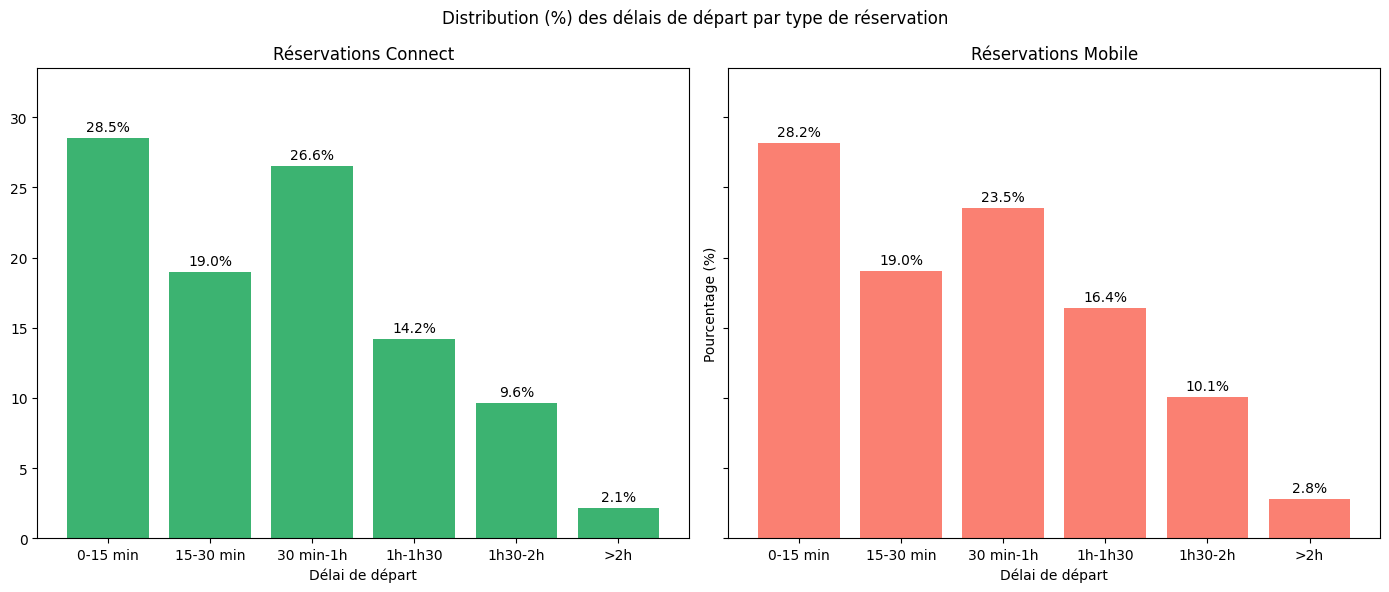

In [20]:
# Séparer les types de check-in
mobile = positive_delays_cleaner[positive_delays_cleaner['checkin_type'] == 'mobile']
connect = positive_delays_cleaner[positive_delays_cleaner['checkin_type'] == 'connect']

# Comptes en pourcentage
mobile_pct = mobile['delay_category'].value_counts(normalize=True).sort_index() * 100
connect_pct = connect['delay_category'].value_counts(normalize=True).sort_index() * 100

# 📊 Affichage des histogrammes en pourcentage
fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Connect
axes[0].bar(connect_pct.index, connect_pct.values, color='mediumseagreen')
axes[0].set_title('Réservations Connect')
axes[0].set_xlabel('Délai de départ')
for i, v in enumerate(mobile_pct):
    axes[1].text(i, v + 0.5, f"{v:.1f}%", ha='center')
for i, v in enumerate(connect_pct):
    axes[0].text(i, v + 0.5, f"{v:.1f}%", ha='center')

# Mobile
axes[1].bar(mobile_pct.index, mobile_pct.values, color='salmon')
axes[1].set_title('Réservations Mobile')
axes[1].set_xlabel('Délai de départ')
axes[1].set_ylabel('Pourcentage (%)')
axes[1].set_ylim(0, max(mobile_pct.max(), connect_pct.max()) + 5)



# Titre général
plt.suptitle('Distribution (%) des délais de départ par type de réservation')
plt.tight_layout()
plt.show()



Now we can calculate the loss of revenues, considering we could put an penality of 10 € for each 15 min delayed and an amount of 200€ above 2h delayed

In [21]:
import pandas as pd
import plotly.express as px

# Filtrer les réservations terminées avec un retard > 0
df = positive_delays_cleaner[
    (positive_delays_cleaner['state'] == 'ended') &
    (positive_delays_cleaner['delay_at_checkout_in_minutes'] > 0 )&
     (positive_delays_cleaner['delay_at_checkout_in_minutes'] < 8000)].copy()

# Dictionnaire des pertes fixes par tranche de retard
loss_per_bin = {
    '0-15 min': 10,
    '15-30 min': 20,
    '30 min-1h': 40,
    '1h-1h30': 60,
    '1h30-2h': 80,
    '>2h': 200
}
df['delay_category'] = df['delay_category'].astype(str)
# Ajouter la perte estimée en fonction de la catégorie
df['estimated_loss'] = df['delay_category'].map(loss_per_bin)

# Grouper par catégorie et type de check-in
loss_by_category = df.groupby(['delay_category', 'checkin_type'])['estimated_loss'].sum().reset_index()

# Visualisation avec Plotly
fig = px.bar(
    loss_by_category,
    x='delay_category',
    y='estimated_loss',
    color='checkin_type',
    barmode='group',
    text=loss_by_category['estimated_loss'].apply(lambda x: f"{x:.0f} €"),
        color_discrete_map={
        'mobile': 'salmon',   # rouge
        'connect': 'mediumseagreen' },
    labels={
        'delay_category': 'Tranche de retard',
        'estimated_loss': 'Perte estimée (€)',
        'checkin_type': 'Type de check-in'
    },
    title="💸 Perte de revenu estimée par tranche de retard (forfaitaire)"
)

fig.update_traces(textposition='outside')
fig.update_layout(
    yaxis_title="Perte estimée (€)",
    xaxis_title="Tranche de retard",
    yaxis_range=[0, loss_by_category['estimated_loss'].max() *1.1]
)

fig.show()

***2- How many rentals would be affected by the feature depending on the threshold and scope we choose?***

In [30]:
import plotly.express as px

fig = px.histogram(
    positive_delays_cleaner,
    x='delay_at_checkout_in_minutes',
    nbins=50,
    title='Distribution of Delays at Checkout (in minutes)',
    labels={'delay_at_checkout_in_minutes': 'Delay at Checkout (minutes)'},
    color='checkin_type'
)

fig.update_layout(
    yaxis_title='Number of Rentals',
    bargap=0.1,
    template='simple_white'
)

fig.show()

In [23]:
# Define different delay thresholds (in minutes)
thresholds = [0, 15, 30, 60,90, 120]

# Calculate the number of rentals that exceed each threshold
affected_rentals = {}
for threshold in thresholds:
    affected_count = positive_delays_cleaner[positive_delays_cleaner['delay_at_checkout_in_minutes'] > threshold].shape[0]
    affected_rentals[threshold] = affected_count

# Convert to DataFrame for easier visualization
affected_rentals_df = pd.DataFrame(list(affected_rentals.items()), columns=['Threshold (minutes)', 'Number of Affected Rentals'])

# Display the DataFrame
print(affected_rentals_df)

   Threshold (minutes)  Number of Affected Rentals
0                    0                        7041
1                   15                        5053
2                   30                        3715
3                   60                        2023
4                   90                         894
5                  120                         190


Poursuivons maintenant notre étude sur les cas annulés : <br>

- Est-ce que les retards très longs (>30 min, >1h…) sont plus associés aux cancellations que les retards mineurs ?<br>
- Créer des bins de retard et voir si la part d’annulations augmente avec la durée du retard précédent.<br>
- Vérifie si les annulations surviennent lorsque le temps entre deux locations est très court (ex: <30 minutes), ce qui rend les retards critiques.

***3.
À quelle fréquence les conducteurs sont-ils en retard pour le check-in suivant ? Comment cela impacte-t-il le conducteur suivant ?***

In [27]:
# Exemple : uniquement connect, et seuil de 15 minutes
scope = 'connect'
delay_threshold = 15
affected = positive_delays_cleaner[
    (positive_delays_cleaner['checkin_type'] == scope) &
    (positive_delays_cleaner['delay_at_checkout_in_minutes'] > delay_threshold)
]

affected_rentals_count = len(affected)
print(affected_rentals_count)


875


In [40]:
# Fusion des données entre une location et la précédente (pour retrouver leur lien)
df_chain = positive_delays_cleaner.dropna(subset=['previous_ended_rental_id', 'time_delta_with_previous_rental_in_minutes'])

# On regarde où le retard du précédent est supérieur au temps entre les deux locations
df_chain = df_chain.merge(
    positive_delays_cleaner[['rental_id', 'delay_at_checkout_in_minutes']],
    left_on='previous_ended_rental_id',
    right_on='rental_id',
    suffixes=('', '_previous')
)
# Définir la limite maximale des axes
x_max = df_chain['time_delta_with_previous_rental_in_minutes'].max() + 30
y_max = df_chain['delay_at_checkout_in_minutes_previous'].max() + 30

fig = px.scatter(
    df_chain,
    x='time_delta_with_previous_rental_in_minutes',
    y='delay_at_checkout_in_minutes_previous',
    title="Propagation potentielle des retards entre locations",
    labels={
        'time_delta_with_previous_rental_in_minutes': 'Temps entre deux locations (min)',
        'delay_at_checkout_in_minutes_previous': 'Retard du véhicule précédent (min)'
    },
    color='checkin_type',  # si utile
    hover_data=['rental_id', 'previous_ended_rental_id']
)

# Ligne y = x (zone critique)
fig.add_shape(
    type="line",
    x0=0, y0=0,
    x1=min(x_max, y_max),
    y1=min(x_max, y_max),
    line=dict(dash="dash", color="red"),
    name="Limite critique"
)

# Limiter les axes
fig.update_layout(
    xaxis=dict(range=[0, x_max]),
    yaxis=dict(range=[0, y_max]),
    template='simple_white'
)

fig.show()

In [36]:
# Cas où le précédent est en retard et empiète sur le suivant
df_chain['is_late_for_next'] = df_chain['delay_at_checkout_in_minutes_previous'] > df_chain['time_delta_with_previous_rental_in_minutes']

late_cases = df_chain[df_chain['is_late_for_next']]
frequency = len(late_cases) / len(df_chain)


In [41]:
# Définir les limites des axes
x_max = df_chain['time_delta_with_previous_rental_in_minutes'].max() + 30
y_max = df_chain['delay_at_checkout_in_minutes_previous'].max() + 30

# Séparer les cas critiques (retard empiète sur le suivant)
df_chain['is_late_for_next'] = df_chain['delay_at_checkout_in_minutes_previous'] > df_chain['time_delta_with_previous_rental_in_minutes']
late_cases = df_chain[df_chain['is_late_for_next']]
on_time_cases = df_chain[~df_chain['is_late_for_next']]

# Créer le scatter plot avec deux groupes
fig = go.Figure()

# 🔵 Cas normaux
fig.add_trace(go.Scatter(
    x=on_time_cases['time_delta_with_previous_rental_in_minutes'],
    y=on_time_cases['delay_at_checkout_in_minutes_previous'],
    mode='markers',
    name='Pas de chevauchement',
    marker=dict(color='skyblue', size=6),
    hoverinfo='text',
    hovertext=on_time_cases['rental_id']
))

# 🔴 Cas critiques
fig.add_trace(go.Scatter(
    x=late_cases['time_delta_with_previous_rental_in_minutes'],
    y=late_cases['delay_at_checkout_in_minutes_previous'],
    mode='markers',
    name='Chevauchement critique',
    marker=dict(color='crimson', size=7, symbol='x'),
    hoverinfo='text',
    hovertext=late_cases['rental_id']
))

# Ligne diagonale de référence y = x
fig.add_shape(
    type="line",
    x0=0, y0=0,
    x1=min(x_max, y_max),
    y1=min(x_max, y_max),
    line=dict(color='gray', dash='dash'),
    name="Limite critique"
)

# Mise en page
fig.update_layout(
    title="Propagation des retards entre deux locations successives",
    xaxis_title='Temps libre entre deux locations (minutes)',
    yaxis_title='Retard du véhicule précédent (minutes)',
    xaxis=dict(range=[0, x_max]),
    yaxis=dict(range=[0, y_max]),
    template='simple_white',
    legend=dict(title='Cas')
)

fig.show()

# Fréquence des cas critiques
frequency = len(late_cases) / len(df_chain)
print(f"Fréquence des cas critiques : {frequency:.2%}")

Fréquence des cas critiques : 23.46%


In [42]:
# Cas où le précédent était en retard ET a empiété sur le suivant
late_cases = df_chain[df_chain['is_late_for_next']]

# Parmi ceux-ci, combien ont été annulés ?
canceled_due_to_previous_delay = late_cases[late_cases['state'] == 'canceled']

# Calcul du nombre et de la part
num_canceled = len(canceled_due_to_previous_delay)
total_late_cases = len(late_cases)
share_canceled = num_canceled / total_late_cases if total_late_cases > 0 else 0

print(f"Nombre de cas critiques : {total_late_cases}")
print(f"Nombre de cas annulés parmi eux : {num_canceled}")
print(f"Part des cas annulés : {share_canceled:.2%}")

import plotly.express as px
import pandas as pd

bar_data = pd.DataFrame({
    'Statut': ['Non annulés', 'Annulés'],
    'Nombre': [total_late_cases - num_canceled, num_canceled]
})

fig = px.bar(bar_data, x='Statut', y='Nombre',
             title="Impact des retards du véhicule précédent sur les annulations",
             color='Statut',
             text='Nombre',
             color_discrete_sequence=['mediumseagreen', 'crimson'])

fig.update_layout(yaxis_title='Nombre de locations')
fig.show()

Nombre de cas critiques : 61
Nombre de cas annulés parmi eux : 0
Part des cas annulés : 0.00%


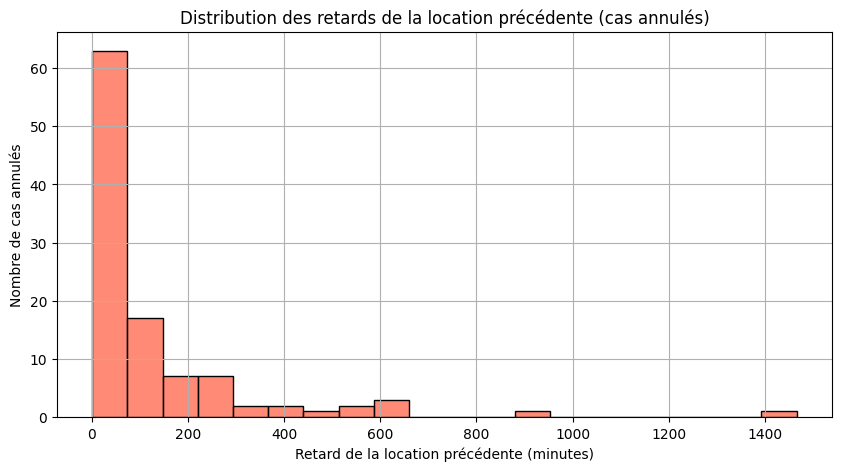

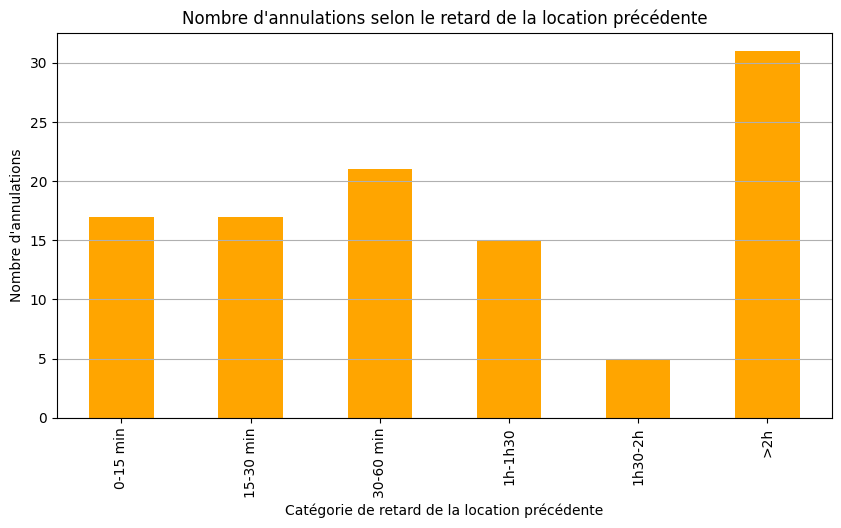

Cas critiques potentiels (retard + turnover < 30 min): 17


In [26]:
import seaborn as sns
import matplotlib.pyplot as plt



# On ne garde que les retards positifs
delays = merged[merged['delay_at_checkout_in_minutes_previous'] > 0]

#Les véhicules précédents sont-ils souvent en retard dans les cas annulés ?

# Histogramme des retards précédents (en minutes)
plt.figure(figsize=(10, 5))
sns.histplot(delays['delay_at_checkout_in_minutes_previous'], bins=20, color='tomato')
plt.title('Distribution des retards de la location précédente (cas annulés)')
plt.xlabel('Retard de la location précédente (minutes)')
plt.ylabel('Nombre de cas annulés')
plt.grid(True)
plt.show()

#Créer des bins de retard et voir si la part d’annulations augmente avec la durée du retard précédent.
# Plus le retard est long, plus le risque d’annulation est-il élevé ?

bins = [0, 15, 30, 60, 90, 120, float('inf')]
labels = ['0-15 min', '15-30 min', '30-60 min', '1h-1h30', '1h30-2h', '>2h']

merged['previous_delay_category'] = pd.cut(
    merged['delay_at_checkout_in_minutes_previous'],
    bins=bins,
    labels=labels
)

delay_impact = merged['previous_delay_category'].value_counts().sort_index()

# Affichage
delay_impact.plot(kind='bar', color='orange', figsize=(10, 5))
plt.title("Nombre d'annulations selon le retard de la location précédente")
plt.xlabel("Catégorie de retard de la location précédente")
plt.ylabel("Nombre d'annulations")
plt.grid(axis='y')
plt.show()




In [31]:
# Analyser les cas où l’intervalle est court ET il y a un retard précédent
merged['short_turnaround'] = merged['time_delta_with_previous_rental_in_minutes'] < 30
merged['was_late'] = merged['delay_at_checkout_in_minutes_previous'] > 0

# Croisement des deux conditions
conflict_cases = merged[merged['short_turnaround'] & merged['was_late']]
print(f"Cas critiques potentiels (retard + turnover < 30 min): {conflict_cases.shape[0]}")#

Cas critiques potentiels (retard + turnover < 30 min): 17


In [32]:
# quel était le type de check-in de la location annulée (mobile vs connect) <br>
# On crée les flags
merged['was_late'] = merged['delay_at_checkout_in_minutes_previous'] > 0
merged['short_turnaround'] = merged['time_delta_with_previous_rental_in_minutes'] < 30

# Cas critiques : retard + délai court
merged['critical_case'] = merged['was_late'] & merged['short_turnaround']

# Analyse par type de check-in
checkin_impact = merged.groupby(['checkin_type', 'critical_case']).size().unstack(fill_value=0)

# Ajout des pourcentages
checkin_impact['Total'] = checkin_impact.sum(axis=1)
checkin_impact['% critiques'] = (checkin_impact[True] / checkin_impact['Total']) * 100

print(checkin_impact)

critical_case  False  True  Total  % critiques
checkin_type                                  
connect          121    10    131     7.633588
mobile            91     7     98     7.142857


***4. How many problematic cases will it solve depending on the chosen threshold and scope?***

In [46]:
#	Prendre les cas problématiques identifiés ci-dessus.
#	Voir combien dépassements seraient évités si un seuil de temps minimal (buffer) était appliqué.

# Nouveau seuil de tampon minimal entre deux locations (ex: 30 minutes)
import pandas as pd
import plotly.express as px

# Liste de seuils à tester
buffers = [15, 30, 45, 60]

# Liste pour stocker les résultats
results = []

# Boucle sur les seuils pour compter les cas résolus
for buffer in buffers:
    resolved_cases = late_cases[late_cases['delay_at_checkout_in_minutes_previous'] <= buffer]
    results.append({'Buffer (min)': buffer, 'Cas résolus': len(resolved_cases)})

# Transformer en DataFrame
results_df = pd.DataFrame(results)

# Visualisation
fig = px.bar(
    results_df,
    x='Buffer (min)',
    y='Cas résolus',
    text='Cas résolus',
    title='Nombre de cas critiques évités selon le buffer de sécurité appliqué',
    color='Cas résolus',
    color_continuous_scale='Blues'
)

fig.update_layout(
    xaxis_title='Seuil de buffer appliqué (minutes)',
    yaxis_title='Nombre de chevauchements évités',
    template='simple_white'
)
fig.show()
